# Inner Speech Dataset Tutorial: Brain-Computer Interface for Thought Classification

Carl re-made a comprehensive tutorial notebook to help you understand the Inner Speech Dataset and how to work with EEG recordings of directional thoughts. This is designed for beginners with detailed explanations at each step because Carl couldn't understand the official tutorial.

# Brain-Computer Interface: Inner Speech Classification Tutorial

This notebook provides a step-by-step guide to working with the Inner Speech Dataset, which contains EEG recordings of people thinking about directional commands ("up", "down", "left", "right").

## 1. Introduction to the Dataset

The Inner Speech Dataset contains EEG recordings from 10 subjects performing three different types of tasks:

- **Inner Speech**: Thinking about directional words without speaking (mental speech)
- **Visualized**: Visualizing/imagining the direction without speaking
- **Pronounced**: Actually speaking the directional words out loud

Each subject performed multiple trials across three experimental sessions. The raw data consists of:
- 128-channel EEG recordings (brain activity)
- Additional physiological measurements (muscle, eye, and heart activity)
- Event markers indicating trial timing and conditions

## 2. Setup and Dependencies

First, we'll install the required libraries and clone the dataset repository.

In [ ]:
# Install and import necessary packages
# !git clone https://github.com/N-Nieto/Inner_Speech_Dataset -q
# %pip install mne matplotlib numpy scipy scikit-learn -q

Note: you may need to restart the kernel to use updated packages.


In [1]:
# Import required libraries
import mne
import warnings
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from pathlib import Path
import sys

# Add the Inner Speech Dataset repository to the system path
sys.path.append(str(Path.cwd() / "Python_Processing"))

# Import custom functions from the Inner Speech Dataset repository
from lib.data_extractions import (
    extract_data_from_subject,
)
from lib.data_processing import (
    select_time_window,
    transform_for_classificator,
)


# Set random seed for reproducibility
np.random.seed(23)

# Configure MNE to show only warnings (suppress info messages)
mne.set_log_level(verbose="warning")

# Suppress deprecation and future warnings
warnings.filterwarnings(action="ignore", category=DeprecationWarning)
warnings.filterwarnings(action="ignore", category=FutureWarning)

print("Setup complete! All libraries imported successfully.")

Setup complete! All libraries imported successfully.


## 3. Understanding the Data Structure

The Inner Speech Dataset is organized as follows:

- **Subjects**: 10 participants (numbered 1-10)
- **Sessions**: Each subject completed 3 experimental blocks/sessions
- **Conditions**: Each trial belongs to one of three conditions:
  - Pronounced (spoken out loud)
  - Inner Speech (thinking only)  
  - Visualized (mentally visualized)
- **Classes**: Each trial involves thinking about one direction:
  - Up
  - Down
  - Left
  - Right

### Data Types Available:
1. **EEG**: Brain activity from 128 electrodes on the scalp
2. **EXG**: External physiological signals including:
   - EMG (electromyography) - muscle activity
   - EOG (electrooculography) - eye movements
   - ECG (electrocardiography) - heart activity
3. **Baseline**: Resting state brain activity when no task is performed

Let's now set up the parameters for our analysis:

In [2]:
# Set the hyperparameters for data loading and processing

# Directory containing the dataset (adjust this to your local path)
root_dir = Path.cwd().parent / "ds003626" # Path to the dataset

# Specify which type of data to use
# Options: "EEG" (brain activity), "exg" (physiological signals), or "baseline" (resting state)
datatype = "EEG"

# EEG sampling rate (256 samples per second)
fs = 256

# Select the time window of interest (in seconds)
# The cue appears at t=0, action period is between 1.5s and 3.5s
t_start = 1.5  # Start time after cue
t_end = 3.5  # End time after cue

# Subject to analyze (1-10)
N_S = 1  # We'll start with subject 1

print(
    f"Parameters set: Using {datatype} data from subject {N_S}, analyzing time window {t_start}s to {t_end}s"
)

Parameters set: Using EEG data from subject 1, analyzing time window 1.5s to 3.5s


## 4. Loading and Exploring the Data

Now we'll load data from the selected subject. The dataset contains three experimental blocks for each subject, and our custom function will automatically load and combine all blocks.

The data is returned in two arrays:
- **X**: The EEG signals [trials × channels × time points]
- **Y**: The event labels [trials × 4], where each row contains:
  - Column 0: Timestamp
  - Column 1: Direction class (0=up, 1=down, 2=right, 3=left)
  - Column 2: Condition (0=pronounced, 1=inner speech, 2=visualized)
  - Column 3: Session number

Let's load the data and examine its structure:

In [3]:
# Load all trials for the selected subject
# This combines data from all three experimental blocks
X, Y = extract_data_from_subject(root_dir, N_S, datatype)

print("Data successfully loaded!")
print("\nX (EEG data) shape:", X.shape)
print("  - Number of trials:", X.shape[0])
print("  - Number of EEG channels:", X.shape[1])
print("  - Number of time points per trial:", X.shape[2])
print("  - Total duration per trial:", X.shape[2] / fs, "seconds")

print("\nY (labels) shape:", Y.shape)
print("  - Number of trials:", Y.shape[0])
print("  - Label information columns:", Y.shape[1])

# Check how many trials we have of each condition and direction
conditions = ["Pronounced", "Inner Speech", "Visualized"]
directions = ["Up", "Down", "Right", "Left"]

print("\nNumber of trials per condition:")
for i, condition in enumerate(conditions):
    condition_count = np.sum(Y[:, 2] == i)
    print(f"{condition}: {condition_count}")

print("\nNumber of trials per direction:")
for i, direction in enumerate(directions):
    direction_count = np.sum(Y[:, 1] == i)
    print(f"{direction}: {direction_count}")

Data successfully loaded!

X (EEG data) shape: (500, 128, 1153)
  - Number of trials: 500
  - Number of EEG channels: 128
  - Number of time points per trial: 1153
  - Total duration per trial: 4.50390625 seconds

Y (labels) shape: (500, 4)
  - Number of trials: 500
  - Label information columns: 4

Number of trials per condition:
Pronounced: 100
Inner Speech: 200
Visualized: 200

Number of trials per direction:
Up: 125
Down: 125
Right: 125
Left: 125


## 5. Data Processing - Selecting the Relevant Time Window

The trials in this dataset are recorded over a longer time period than we need. Each trial includes:
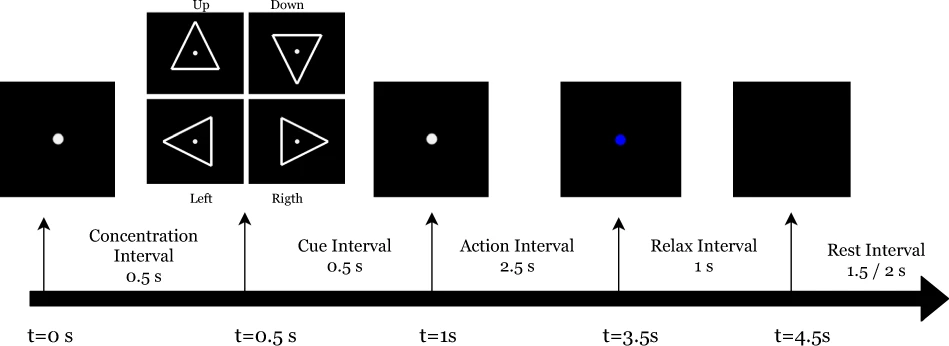
- Pre-stimulus period (-0.5 to 0s)
- Cue presentation (0 to 0.5s)
- Action period (0.5 to 3.5s) 
- Rest period (3.5 to 4s)

For classification, we want to focus on the period when the subject is actively thinking about the direction. Based on the experimental design, this occurs between 1.5 and 3.5 seconds after the cue.

Let's select this time window from our data:

In [4]:
# Extract only the relevant time window from each trial
# X goes from [trials × channels × full_time_points] to [trials × channels × selected_time_points]
X = select_time_window(X=X, t_start=t_start, t_end=t_end, fs=fs)

print("Time window selection complete!")
print("\nNew X (EEG data) shape:", X.shape)
print("  - Number of trials:", X.shape[0])
print("  - Number of EEG channels:", X.shape[1])
print("  - Number of time points per trial:", X.shape[2])
print("  - Selected duration per trial:", X.shape[2] / fs, "seconds")

# Calculate how many data points were selected
total_data_points = X.shape[0] * X.shape[1] * X.shape[2]
print(f"\nTotal data points in selected window: {total_data_points:,}")

Time window selection complete!

New X (EEG data) shape: (500, 128, 512)
  - Number of trials: 500
  - Number of EEG channels: 128
  - Number of time points per trial: 512
  - Selected duration per trial: 2.0 seconds

Total data points in selected window: 32,768,000


# Understanding Task Selection in the Inner Speech Dataset

## Why Filter Specific Mental Tasks?

When working with the Inner Speech dataset, you'll often want to focus on specific mental tasks to:

1. **Simplify analysis**: Comparing just two conditions makes patterns easier to identify
2. **Reduce computational requirements**: Using a subset of data speeds up processing
3. **Answer specific research questions**: "Can we distinguish between thinking 'up' vs 'down'?"

## What Your Raw Data Looks Like

Before filtering, your data contains trials spanning all conditions and directions:

| Trial | Timestamp | Direction | Condition | Session |
|-------|-----------|-----------|-----------|---------|
| 1     | 1591871042| Up (0)    | Inner (1) | 1       |
| 2     | 1591871045| Left (3)  | Inner (1) | 1       |
| 3     | 1591871049| Down (1)  | Pronounced (0) | 1  |
| 4     | 1591871054| Right (2) | Inner (1) | 1       |
| 5     | 1591871060| Up (0)    | Visualized (2) | 1  |
| ...   | ...       | ...       | ...       | ...     |

## How to Select Different Tasks

You can easily modify which mental tasks to compare by changing these variables:

```python
# To compare "Up" vs "Down" in inner speech:
Conditions = [["Inner"], ["Inner"]]
Classes = [["Up"], ["Down"]]

# To compare "Left" vs "Right" in inner speech:
Conditions = [["Inner"], ["Inner"]]
Classes = [["Left"], ["Right"]]

# To compare inner speech vs. visualization of "Up":
Conditions = [["Inner"], ["Vis"]]
Classes = [["Up"], ["Up"]]

# To compare all four directions in inner speech:
Conditions = [["Inner"], ["Inner"], ["Inner"], ["Inner"]]
Classes = [["Up"], ["Down"], ["Left"], ["Right"]]
```

## Why "Up" vs "Down"?

These directions make a good starting point because:

1. They represent **opposite concepts** (vertical axis)
2. They likely activate **different brain regions**
3. The **motor imagery** for these directions is distinct
4. The **simplicity** of a binary classification problem

## For First-Time Users

When experimenting with the dataset:

- Start with binary comparisons (like "Up" vs "Down") to learn the patterns
- Try different conditions (Inner/Visualized/Pronounced) to see how they differ
- Explore both similar directions (Up/Down) and orthogonal ones (Left/Right)
- Check the sample counts after filtering to ensure enough data remains:
  ```python
  print(f"Number of 'Up' trials: {np.sum(Y == 0)}")
  print(f"Number of 'Down' trials: {np.sum(Y == 1)}")
  ```

As you get comfortable, you can expand to multi-class problems or investigate how the same direction varies across different mental strategies (Inner vs. Visualized).

In [5]:
# First, let's reload the original data for our subject
X, Y = extract_data_from_subject(root_dir, N_S, datatype)

# Extract only the relevant time window
X = select_time_window(X=X, t_start=t_start, t_end=t_end, fs=fs)

# Define which conditions and classes we want to compare
# We'll compare "Up" vs "Down" in the "Inner Speech" condition
Conditions = [["Inner"], ["Inner"]]  # Both groups use Inner Speech condition
Classes = [["Up"], ["Down"]]  # First group is "Up", second is "Down"

print("Filtering data to compare:")
print(f"- Group 1: {Classes[0][0]} direction in {Conditions[0][0]} condition")
print(f"- Group 2: {Classes[1][0]} direction in {Conditions[1][0]} condition")

# Transform and filter the data to keep only trials of interest
X, Y = transform_for_classificator(X, Y, Classes, Conditions)

print("\nAfter filtering:")
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("\nY now contains simple binary labels:")
print("- 0 represents:", Classes[0][0])
print("- 1 represents:", Classes[1][0])

# Check how many trials we have for each class
n_up = np.sum(Y == 0)
n_down = np.sum(Y == 1)
print(f"\nNumber of '{Classes[0][0]}' trials: {n_up}")
print(f"Number of '{Classes[1][0]}' trials: {n_down}")

Filtering data to compare:
- Group 1: Up direction in Inner condition
- Group 2: Down direction in Inner condition

After filtering:
X shape: (100, 128, 512)
Y shape: (100,)

Y now contains simple binary labels:
- 0 represents: Up
- 1 represents: Down

Number of 'Up' trials: 50
Number of 'Down' trials: 50


## 7. Data Visualization - Understanding Brain Activity

Let's visualize the EEG data to better understand what we're working with. We'll create two visualizations:

1. **Average signal across trials**: This shows how the brain signal changes over time for each direction
2. **Topographic maps**: These show the distribution of brain activity across the scalp

Let's start with plotting the average EEG from a central electrode:

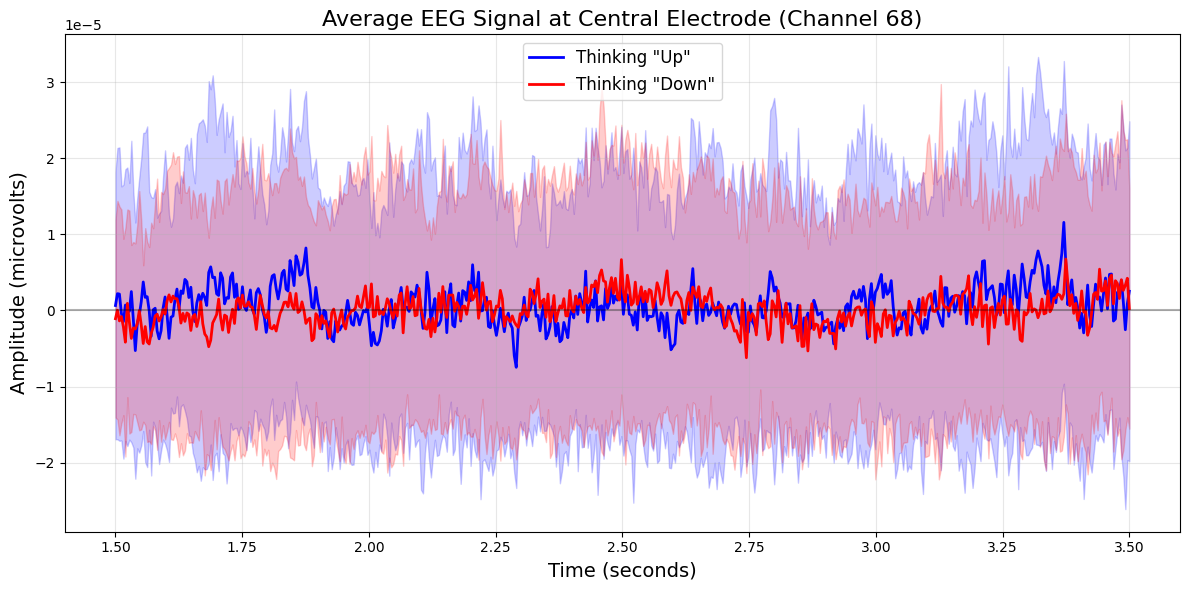

The plot shows how brain activity differs when thinking 'Up' versus 'Down'.
Notice the subtle differences in the patterns between the two mental tasks.


In [6]:
# Choose a central electrode to visualize (e.g., Cz which is typically electrode 65)
electrode_idx = 68  # This might need adjustment based on the actual channel layout

# Calculate means for each class
up_trials = X[Y == 0]
down_trials = X[Y == 1]

up_mean = np.mean(up_trials[:, electrode_idx, :], axis=0)
down_mean = np.mean(down_trials[:, electrode_idx, :], axis=0)

# Create a time vector (in seconds)
time = np.linspace(t_start, t_end, X.shape[2])
# Plot the average signals
plt.figure(figsize=(12, 6))

# Calculate standard deviation for both classes to show variability
up_std = np.std(up_trials[:, electrode_idx, :], axis=0)
down_std = np.std(down_trials[:, electrode_idx, :], axis=0)

# Plot mean lines
plt.plot(time, up_mean, "b-", linewidth=2, label='Thinking "Up"')
plt.plot(time, down_mean, "r-", linewidth=2, label='Thinking "Down"')

# Add shaded areas for standard deviation to show variability
plt.fill_between(time, up_mean - up_std, up_mean + up_std, color="blue", alpha=0.2)
plt.fill_between(
    time, down_mean - down_std, down_mean + down_std, color="red", alpha=0.2
)

# Add horizontal line at zero
plt.axhline(y=0, color="k", linestyle="-", alpha=0.3)
plt.grid(True, alpha=0.3)

# Add title and labels
plt.title(
    f"Average EEG Signal at Central Electrode (Channel {electrode_idx})", fontsize=16
)
plt.xlabel("Time (seconds)", fontsize=14)
plt.ylabel("Amplitude (microvolts)", fontsize=14)
plt.legend(fontsize=12)
plt.tight_layout()
plt.show()

print("The plot shows how brain activity differs when thinking 'Up' versus 'Down'.")
print("Notice the subtle differences in the patterns between the two mental tasks.")

## 8. Feature Extraction

For machine learning, we need to convert our 3D EEG data [trials × channels × time points]
into a 2D feature matrix [trials × features]. We have several options:

1. Use the raw EEG values (flatten the channel and time dimensions)
2. Calculate frequency-based features (power in different frequency bands)
3. Create time-window averages to reduce dimensionality

For simplicity, we'll use approach #1 and flatten the data:

- Each trial becomes a single row
- Each channel-timepoint combination becomes a feature
- For example, with 128 channels and 512 time points, each trial would have 65,536 features

This approach preserves all the raw information but creates high-dimensional data which can lead to overfitting. More advanced approaches might use frequency analysis (FFT) or spatial filtering (CSP) to extract more meaningful features.

# Understanding Feature Extraction for Brain Data: A Neuroscience Perspective

When analyzing brain data for classification, we need to transform the raw EEG signals into meaningful "features" that a machine learning algorithm can use. This step is crucial because it determines what aspects of brain activity we're actually using to detect different thoughts.

## Why We Need Feature Extraction

Brain signals are incredibly complex - they contain information about countless simultaneous neural processes. The three feature extraction approaches each capture different aspects of how the brain processes information:

### 1. Raw EEG Values (Flattening)

**Neuroscience basis:** The brain's electrical activity directly reflects neural firing patterns. Every fluctuation in voltage represents coordinated activity of thousands of neurons.

**Example:** When you think "up," specific neural populations in your motor and language areas activate in a particular temporal pattern. These create unique electrical "signatures" in the raw EEG.

**Pros:**
- Preserves all temporal dynamics (like the exact timing of neural responses)
- Captures the full spatial pattern across the scalp
- Requires minimal assumptions about what's "important" in the signal

**Real-world analogy:** This is like giving someone the complete transcript of a conversation rather than a summary - all information is preserved, but it might be overwhelming.

### 2. Frequency-Based Features (Power in Different Bands)

**Neuroscience basis:** The brain operates through oscillations at different frequencies, each associated with specific cognitive functions:
- Delta (0.5-4 Hz): Deep sleep, unconscious processes
- Theta (4-8 Hz): Memory formation, emotional processing
- Alpha (8-12 Hz): Relaxed awareness, inhibition
- Beta (12-30 Hz): Active thinking, focus, motor planning
- Gamma (30+ Hz): Complex cognitive processing, consciousness

**Example:** Inner speech often involves increased beta activity over language areas and suppressed alpha activity (which indicates active processing rather than idling).

**Pros:**
- Directly relates to known brain mechanisms
- Reduces dimensionality while preserving meaningful information
- Robust to timing variations between trials

**Real-world analogy:** This is like analyzing someone's tone of voice rather than their exact words - rhythms and patterns often convey the most important information.

### 3. Time-Window Averages

**Neuroscience basis:** Brain processing happens in functional "chunks" - neural responses have characteristic time courses with preparatory, execution, and feedback phases.

**Example:** When processing a directional thought, your brain might show:
- Initial activation (0-250ms): Visual/cue processing
- Mid-phase (250-500ms): Decision making
- Late phase (500ms+): Mental visualization or inner speech

**Pros:**
- Captures the evolution of brain activity over time
- Reduces noise by averaging within functional time periods
- Preserves temporal sequence while reducing dimensions

**Real-world analogy:** This is like summarizing each paragraph of text rather than analyzing each word - you capture the progression of ideas without overwhelming detail.

## Why Raw Flattening is a Good Starting Point

For beginners, starting with flattened raw data makes sense because:

1. It preserves all information for the algorithm to learn from
2. It doesn't require advanced neuroscience knowledge to implement
3. It serves as a baseline to compare against more sophisticated approaches

Later, you might explore more advanced approaches like:
- Common Spatial Patterns (CSP): Finds spatial filters that maximize differences between classes
- Riemannian geometry: Works with covariance matrices to capture relationships between channels
- Wavelet decomposition: Analyzes time-frequency characteristics simultaneously

Each of these methods emphasizes different aspects of how your brain encodes the thought of "up," "down," "left," or "right" in its electrical activity.

In [7]:
# Reshape X from [trials × channels × time points] to [trials × features]
# where features = channels * time points
n_trials = X.shape[0]
n_features = X.shape[1] * X.shape[2]  # channels * time points

# Flatten each trial into a single feature vector
X_features = X.reshape(n_trials, n_features)

print(f"Data reshaped from {X.shape} to {X_features.shape}")
print(f"Each trial now has {n_features:,} features")

# Split into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_features, Y, test_size=0.3, random_state=42
)

print(f"\nTraining set: {X_train.shape[0]} trials")
print(f"Testing set: {X_test.shape[0]} trials")

Data reshaped from (100, 128, 512) to (100, 65536)
Each trial now has 65,536 features

Training set: 70 trials
Testing set: 30 trials


## 9. Building a Classifier

Now we'll build a simple classifier to distinguish between "thinking Up" and "thinking Down" based on the brain activity patterns. We'll use a Support Vector Machine (SVM) classifier with standardization of the features.

### Understanding Brain Classification

When we classify brain signals, we're essentially asking:
"Can we identify patterns in brain activity that consistently differ between two mental states?"

This works because:
- Different thoughts activate different neural networks
- These networks create distinct electrical patterns
- Machine learning can identify these subtle differences

### Our Classification Pipeline

The pipeline we'll build consists of two steps:

1. **Standardization (StandardScaler)**
    - Rescales each feature to have zero mean and unit variance
    - Example: If electrode 1 readings range from -50 to +70 μV and electrode 2 ranges from -5 to +5 μV, standardization makes them comparable
    - Before: [-50, 10, 70] → After: [-1.2, 0.24, 1.7] (approximately)
    - Essential for EEG data which can vary widely in scale across electrodes
    - Prevents features with larger values from dominating the model

2. **Support Vector Machine (SVM)**
    - Finds an optimal boundary between brain states
    - Uses a "kernel trick" (RBF) to map data to higher dimensions
    - RBF kernel: Measures similarity based on distance between points
    - Example: Points x₁ and x₂ are transformed using: K(x₁,x₂) = exp(-γ||x₁-x₂||²)
    - Well-suited for complex, non-linear patterns in brain data
    - Brain states often can't be separated by simple linear boundaries

### Key SVM Parameters:
- **kernel="rbf"** - Radial Basis Function kernel transforms data into a feature space where "Up" and "Down" thoughts become more separable
- **C=1.0** - Controls trade-off between smooth decision boundary and classifying training points correctly
- **gamma="scale"** - Determines how far the influence of a single training example reaches

### What Success Means

If our classifier performs significantly better than chance (50%), it demonstrates that:
- The brain produces measurable, distinct patterns when thinking different directions
- These patterns can be detected from scalp EEG recordings
- Brain-computer interfaces based on these signals are feasible

This is the fundamental science behind technologies that allow people to control computers or prosthetics using only their thoughts! For more information on other classifiers, read [this](Tutorial_otherClassifiers.md).

Training the classifier...

Classification accuracy: 46.67%


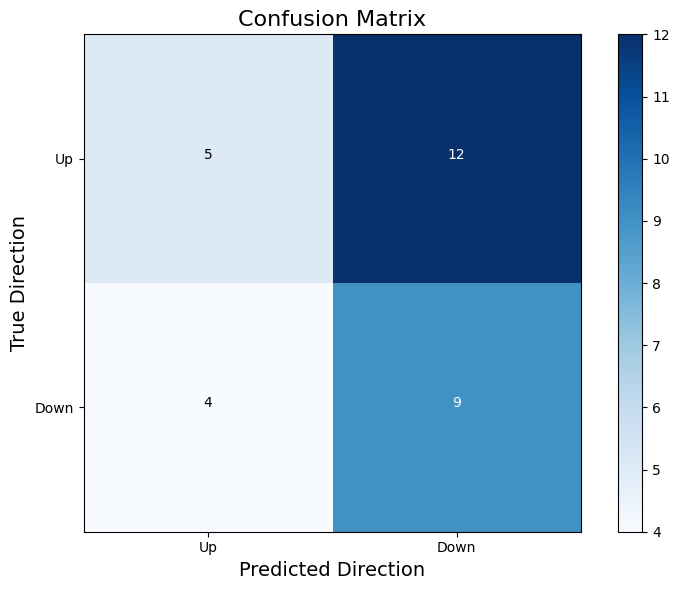


The confusion matrix shows:
- True Up, predicted Up: 5 trials
- True Up, predicted Down: 12 trials
- True Down, predicted Up: 4 trials
- True Down, predicted Down: 9 trials


In [8]:
# Create a pipeline that standardizes the data and then applies SVM
pipeline = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=1.0, gamma="scale", random_state=42)),
    ]
)

# Train the model
print("Training the classifier...")
pipeline.fit(X_train, y_train)

# Make predictions on the test set
y_pred = pipeline.predict(X_test)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred) * 100
print(f"\nClassification accuracy: {accuracy:.2f}%")

# Create and display confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation="nearest", cmap=plt.cm.Blues)
plt.title("Confusion Matrix", fontsize=16)
plt.colorbar()
tick_marks = np.arange(2)
plt.xticks(tick_marks, ["Up", "Down"])
plt.yticks(tick_marks, ["Up", "Down"])
plt.xlabel("Predicted Direction", fontsize=14)
plt.ylabel("True Direction", fontsize=14)

# Add text annotations to the confusion matrix
thresh = cm.max() / 2
for i in range(cm.shape[0]):
    for j in range(cm.shape[1]):
        plt.text(
            j,
            i,
            format(cm[i, j], "d"),
            horizontalalignment="center",
            color="white" if cm[i, j] > thresh else "black",
        )

plt.tight_layout()
plt.show()

print("\nThe confusion matrix shows:")
print(f"- True Up, predicted Up: {cm[0,0]} trials")
print(f"- True Up, predicted Down: {cm[0,1]} trials")
print(f"- True Down, predicted Up: {cm[1,0]} trials")
print(f"- True Down, predicted Down: {cm[1,1]} trials")

## 10. Understanding What We've Accomplished

We have successfully:

1. **Loaded EEG data** from the Inner Speech Dataset
2. **Processed the data** by:
   - Selecting the relevant time window (1.5s to 3.5s)
   - Filtering for specific mental tasks ("Up" vs "Down" in Inner Speech)
3. **Visualized the differences** in brain activity between thinking "Up" and "Down"
4. **Built a classifier**: In this case, the classifier almost always returns "Down", but with more data or better algorithms, we could potentially distinguish between these two mental states


## Next Steps

To improve the classifier, you could:
1. Try different feature extraction methods (frequency bands, spatial filters)
2. Test different machine learning algorithms
3. Add more mental states (e.g., "Left" and "Right")
4. Experiment with real-time classification

## References

- Inner Speech Dataset: https://github.com/N-Nieto/Inner_Speech_Dataset
- Nieto, N.G., Peterson, V., Gonzalez Carpintero, D. et al. Inner speech EEG dataset. Sci Data 9, 521 (2022).